# TinyGPT

**Autor: Abraham R.**


Este cuaderno es un ejemplo de un modelo GPT realmente pequeño llamado **TinyGPT**.
Repasarás la arquitectura GPT (transformer *decoder*) e implementarás las siguientes tareas:

## Arquitectura de TinyGPT

Diseñado para el [curso NLP‑II](https://github.com/FIUBA-Posgra...), consiste en un **GPT con *Mixture of Experts***, equivalente a modelos como:
- DeepSeek
- Mistral

## Tareas

Usando TinyGPT debes implementar las siguientes modificaciones:
...

## Arquitectura
- Convertir TinyGPT en un *Mixture of Experts* (MoE) con al menos 2 expertos.

## ¿Qué esperar?

- Comprender en profundidad la implementación de un modelo GPT.
- Implementar una capa MoE para crear un modelo GPT de vanguardia.
- Explorar algoritmos de decodificación para generación de texto.

### NOTA

La tokenización está fuera de alcance; usaremos un tokenizador por caracteres, sencillo pero ineficiente.


###Trabajo Práctico realizado por Maria Fabiana Cid para la materia PNL2

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from dataclasses import dataclass, field
from typing import Optional, List, Type
import httpx

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR

In [ ]:
from google.colab import drive
import sys, os, glob

# 1. Montar Google Drive
drive.mount('/content/drive')

# 2. Buscar trainer.py en todo tu Drive
resultados = glob.glob("/content/drive/MyDrive/**/trainer.py", recursive=True)

if not resultados:
    raise FileNotFoundError("No se encontró trainer.py en tu Drive. Verifica que el archivo exista.")

# 3. Tomar la primera coincidencia (puedes cambiar si hay varios)
ruta_trainer = resultados[0]
print(f"✅ trainer.py encontrado en: {ruta_trainer}")

# 4. Añadir la carpeta al path de Python
ruta_carpeta = os.path.dirname(ruta_trainer)
if ruta_carpeta not in sys.path:
    sys.path.append(ruta_carpeta)

# 5. Importar Trainer
from trainer import Trainer
print("✅ Importación correcta de Trainer")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ trainer.py encontrado en: /content/drive/MyDrive/trainer.py
✅ Importación correcta de Trainer


## Descargando el conjunto de datos

In [ ]:
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = httpx.get(url)
text = response.text

text = text[:100_000]  # Using 100k characters for speedup
print(text)

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



# Codificación basada en caracteres

In [ ]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}
def encode(s): return [stoi[c] for c in s]
def decode(l): return ''.join([itos[i] for i in l])
data = torch.tensor(encode(text), dtype=torch.long)

# División entrenamiento/prueba
split = int(0.9 * len(data))
train_data = data[:split]
val_data = data[split:]

# Cargadores de datos

In [ ]:
class CharDataset(Dataset):
    def __init__(self, data: torch.Tensor, block_size: int):
        self.data = data
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.block_size]
        y = self.data[idx + 1 : idx + self.block_size + 1]
        return x, y

# Configuración de GPT

In [ ]:
@dataclass
class MoEArgs():
    """
    MoE input arguments class.
    """
    num_experts : int = field(default=4)
    num_experts_per_token : int = field(default=2)

@dataclass
class GPTConfig:
    """
    Base class for GPT models.
    """
    block_size: int = 32
    batch_size: int = 8
    n_embd: int = 64
    n_head: int = 4
    n_layer: int = 2
    dropout: float = 0.1
    vocab_size: int = vocab_size
    bias: bool = True
    ff_class: Optional[Type[nn.Module]] = None
    moe : Optional[MoEArgs] = None

config = GPTConfig()
print(config.__dict__)

{'block_size': 32, 'batch_size': 8, 'n_embd': 64, 'n_head': 4, 'n_layer': 2, 'dropout': 0.1, 'vocab_size': 61, 'bias': True, 'ff_class': None, 'moe': None}


In [ ]:
train_dataset = CharDataset(train_data, config.block_size)
val_dataset = CharDataset(val_data, config.block_size)

train_loader = DataLoader(train_dataset,
                        batch_size=config.batch_size,
                        shuffle=True,
                        drop_last=True,
                        pin_memory=True,
                        num_workers= 8, # if using mps set num_workers as 0.
                        )
val_loader = DataLoader(val_dataset,
                        batch_size=config.batch_size,
                        shuffle=False,
                        drop_last=True,
                        pin_memory=True,
                        num_workers= 8,
                        )

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
class AttentionHead(nn.Module):
    """
    Scaled Dot-Product Attention Head for Multi-Head Attention.
    """
    def __init__(self, args: GPTConfig) -> None:
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.head_dim = args.n_embd // args.n_head

# Proyección QKV combinada
        self.key_query_value = nn.Linear(args.n_embd, 3 * self.head_dim, bias=args.bias)

        self.dropout = nn.Dropout(args.dropout)
        self.block_size = args.block_size
        self.register_buffer('tril', torch.tril(torch.ones(args.block_size, args.block_size)))

    def forward(self, x: torch.Tensor, kv_cache: Optional[torch.Tensor] = None, return_weights=False):
        B, T, C = x.shape
        key_query_value = self.key_query_value(x)  # (B, T, 3 * head_dim)
        k, q, v = torch.chunk(key_query_value, 3, dim=-1)  # (B, T, head_dim) each

        if kv_cache is not None:
            key_cache, value_cache = kv_cache.unbind(dim=0)  # (B, T', head_dim)
            k = torch.cat((key_cache, k), dim=1)
            v = torch.cat((value_cache, v), dim=1)

# Atención de producto punto escalado
        wei = q @ k.transpose(-2, -1) * (self.head_dim ** -0.5)  # (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        out = wei @ v  # (B, T, head_dim)

        if return_weights:
            return out, wei

        if kv_cache is not None:
            return out, torch.stack((k, v))

        return out, None

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, args: GPTConfig):
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.n_heads = args.n_head
        self.head_dim = args.n_embd // args.n_head

        self.heads = nn.ModuleList([
            AttentionHead(args) for _ in range(self.n_heads)
        ])

        self.proj = nn.Linear(args.n_embd, args.n_embd, bias=args.bias)
        self.dropout = nn.Dropout(args.dropout)

    def forward(self, x, kv_cache=None, return_weights=False):
        all_outputs = []
        all_weights = []
        new_kv_cache = [] if kv_cache is not None else None

        for i, head in enumerate(self.heads):
            head_cache = kv_cache[i] if kv_cache is not None else None
            out, weights_or_kv = head(x, kv_cache=head_cache, return_weights=return_weights)
            all_outputs.append(out)
            if return_weights:
                all_weights.append(weights_or_kv)
            if kv_cache is not None:
                new_kv_cache.append(weights_or_kv)  # weights_or_kv is new kv_cache here

        concat = torch.cat(all_outputs, dim=-1)  # concat along embedding dim
        out = self.dropout(self.proj(concat))

        if return_weights:
            return out, torch.stack(all_weights)
        if kv_cache is not None:
            return out, new_kv_cache
        return out

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = MultiHeadAttention(config)

        ff_class = config.ff_class if config.ff_class is not None else FeedForward
        self.ff = ff_class(config)

    def forward(self, x, kv_cache=None, return_weights=False):
        attn_out = self.attn(self.ln1(x), kv_cache=kv_cache, return_weights=return_weights)
        if return_weights:
            attn_out, weights = attn_out
        else:
            weights = None

        if isinstance(attn_out, tuple):
            attn_out, updated_kv = attn_out
        else:
            updated_kv = None

        x = x + attn_out
        x = x + self.ff(self.ln2(x))
        return (x, updated_kv, weights) if return_weights else (x, updated_kv)

## Arquitectura de TinyGPT

In [ ]:
class TinyGPT(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.token_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Embedding(config.block_size, config.n_embd)
        self.blocks = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.config = config

    def forward(self, idx, kv_cache=None, return_weights=False):
        B, T = idx.shape
        tok_emb = self.token_emb(idx)
        pos = torch.arange(T, device=idx.device)
        pos_emb = self.pos_emb(pos)[None, :, :]
        x = tok_emb + pos_emb

        new_kv_cache = [] if kv_cache is not None else None
        all_weights = [] if return_weights else None

        for i, block in enumerate(self.blocks):
            layer_kv = kv_cache[i] if kv_cache is not None else None
            if return_weights:
                x, updated_kv, weights = block(x, kv_cache=layer_kv, return_weights=True)
                all_weights.append(weights)  # weights shape: (n_heads, B, T, T)
            else:
                x, updated_kv = block(x, kv_cache=layer_kv)
            if kv_cache is not None:
                new_kv_cache.append(updated_kv)

        x = self.ln_f(x)
        logits = self.head(x)

        if return_weights:
            if kv_cache is not None:
                return logits, new_kv_cache, all_weights
            else:
                return logits, all_weights
        else:
            if kv_cache is not None:
                return logits, new_kv_cache
            return logits

## Función de generación (inferencia)

In [ ]:
@torch.no_grad()
def generate(prompt: str, max_new_tokens: int = 100, use_cache: bool = True):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        probs = F.softmax(logits[:, -1, :], dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())

# Configuración

In [ ]:
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
m = TinyGPT(config).to(device)
model = torch.compile(m)

In [ ]:
optimizer = AdamW(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 2

# Entrenamiento

In [ ]:
# Instancia del Trainer
trainer = Trainer(
    model=model,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)
# Entrenamiento
for epoch in range(epochs):
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    print(f"Época {epoch+1} - pérdida de entrenamiento: {avg_train_loss:.4f}")

    val_loss = trainer.eval_model()
    print(f"Época {epoch+1} - pérdida de validación: {val_loss:.4f}")

print("Entrenamiento completo.")

  0%|          | 0/11246 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
W0815 14:06:21.021000 176 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode
/usr/local/lib/python3.11/dist-packages/torch/_inductor/compile_fx.py:1948: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/_inductor/compile_fx.py:1948: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/_induc

Época 1 - pérdida de entrenamiento: 2.0910


  0%|          | 0/1246 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val_loss 2.05954: 100%|██████████| 1246/1246 [00:09<00:00, 135.80it/s]


Época 1 - pérdida de validación: 2.0571


loss 2.11004: 100%|██████████| 11246/11246 [03:04<00:00, 60.87it/s]


Época 2 - pérdida de entrenamiento: 2.0931


val_loss 2.05955: 100%|██████████| 1246/1246 [00:09<00:00, 137.22it/s]

Época 2 - pérdida de validación: 2.0571
Entrenamiento completo.


### Prueba rápida

In [ ]:
generate("To be", max_new_tokens=100,use_cache=True)

"To ben on suld uatt?\n\nIf I it nof ' vefor will to 'I top\nShoortt shat we she te alm you Vour sir 's!\nHabp"

# Tarea I

Usando TinyGPT debes implementar las siguientes modificaciones:


## Inferencia: modifica la función `generate` para:
- Decodificación *greedy* (seleccionar el token con mayor probabilidad).
- Muestreo por temperatura.
- Muestreo *top‑k* o *top‑p*.

### Referencias
- [huggingface generate](https://huggingface.co/docs/transformers/main_classes/text_generation)


In [ ]:
# TODO Implementar decodificación Greedy, Temperature y top_k/top_p
@torch.no_grad()
def generateV2(
    prompt: str,
    max_new_tokens: int = 100,
    use_cache: bool = True,
    temperature: float = 1.0,
    top_k: int = 10,
    top_p: float = 0.9,
)-> Optional[str]:

    return None

##Implementación GenerateV2

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

# 1. Configuración rápida
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print("Usando device:", device)

Usando device: cuda


In [ ]:
# 2. TinyGPT ya definido y configurado
model = TinyGPT(config).to(device)

# 3. Dataset y DataLoader rápido
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

#  4. Optimizer y loss
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()


In [ ]:
#  5. Mini ciclo de entrenamiento
epochs = 2  # rápido para prueba
model.train()
for epoch in range(epochs):
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = loss_fn(logits.view(-1, logits.size(-1)), y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}")
print("Mini entrenamiento completo ✅\n")


Epoch 1 - Loss: 1.9699
Epoch 2 - Loss: 1.6521
Mini entrenamiento completo ✅



In [ ]:

#  6. Definición de generateV2
@torch.no_grad()
def generateV2(prompt: str, max_new_tokens: int = 50, use_cache: bool = True,
               mode: str = "greedy", temperature: float = 1.0, top_k: int = 10, top_p: float = 0.9) -> str:
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -1:] if use_cache and kv_cache is not None else idx[:, -config.block_size:]
        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)
        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None
        logits_last = logits[:, -1, :]
        if mode == "greedy":
            next_token = torch.argmax(logits_last, dim=-1, keepdim=True)
        else:
            logits_temp = logits_last / (temperature if temperature > 0 else 1.0)
            if mode == "top_k" and top_k > 0:
                values, _ = torch.topk(logits_temp, k=top_k)
                min_values = values[:, -1].unsqueeze(-1)
                logits_temp[logits_temp < min_values] = -float("Inf")
            if mode == "top_p" and top_p < 1.0:
                sorted_logits, sorted_indices = torch.sort(logits_temp, descending=True)
                probs = F.softmax(sorted_logits, dim=-1)
                cumulative_probs = torch.cumsum(probs, dim=-1)
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[:, 1:] = sorted_indices_to_remove[:, :-1].clone()
                sorted_indices_to_remove[:, 0] = 0
                for b in range(logits_temp.size(0)):
                    logits_temp[b, sorted_indices[b, sorted_indices_to_remove[b]]] = -float("Inf")
            probs = F.softmax(logits_temp, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, next_token), dim=1)
    return decode(idx[0].tolist())

#  7. Tabla comparativa
prompt = "To be"
modos = [
    ("Greedy", "greedy", 0.0, 0, 1.0),
    ("Temperature 0.7", "temperature", 0.7, 0, 1.0),
    ("Top-k 10", "top_k", 1.0, 10, 1.0),
    ("Top-p 0.9", "top_p", 1.0, 0, 0.9)
]

print(f"{'MODO':<20} | TEXTO GENERADO")
print("-"*80)
for nombre, mode, temp, k, p in modos:
    texto = generateV2(prompt, max_new_tokens=50, use_cache=True,
                       mode=mode, temperature=temp, top_k=k, top_p=p)
    print(f"{nombre:<20} | {texto}\n")


MODO                 | TEXTO GENERADO
--------------------------------------------------------------------------------
Greedy               | To be the people,
And the stand the people, and the sha

Temperature 0.7      | To be think to rether prowes; they gods spoil.

MARCIUS

Top-k 10             | To be suffery bore's abonce.

VOLUMNIA:
Ay, neve will b

Top-p 0.9            | To be which it. To courself.

MARCIUS:
Why: Capaitier b



## Comparar `generate` vs `generateV2`

Añade tus comentarios y conclusiones

In [ ]:
result_1 = generate("To be", max_new_tokens=100, use_cache=True)
print("generate:", result_1)

result_2 = generateV2("To be", max_new_tokens=100, use_cache=True)
print("generateV2:", result_2)


generate: To be how us lovess trantrous, they sword,
And perprace as Of I shall to the venters,
Who to not have ree
generateV2: To be the people,
And the stand the people, and the shall be the people,
And the people the stater of the


Generate: Todavía es un poco caótico, con palabras inventadas (trantrous, perprace, venters).

Esto es normal porque solo entrené 2 épocas; el modelo empieza a aprender patrones de palabras y estructuras, pero no tiene suficiente entrenamiento para generar Shakespeare completo.

GnerateV2: Mucho más coherente: ya repite frases comunes y estructuras de oración.

Se nota que el modelo está empezando a captar patrones de repetición y gramática básica.

Esto demuestra que generateV2 ya puede reflejar las diferencias entre modos (greedy, top-k, top-p, temperature) de manera más clara cuando el modelo ha aprendido algo del dataset.

Para lograr que el texto sea más natural y variado, conviene entrenar más épocas y usar modos como temperature 0.7 o top-p 0.9 para generar variedad y evitar repeticiones.

GenerateV2  da la flexibilidad de controlar la creatividad del texto con los distintos modos.

## Tarea II
- Convierte TinyGPT en un *Mixture of Experts* (MoE) con al menos 2 expertos.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
from dataclasses import dataclass, field
from typing import List
import matplotlib.pyplot as plt
import httpx


In [2]:

# Dataset de caracteres

url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = httpx.get(url)
text = response.text[:100_000]

chars = sorted(list(set(text)))
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}

def encode(s):
    return [stoi[c] for c in s]

def decode(l):
    return ''.join([itos[i] for i in l])

class CharDataset(Dataset):
    def __init__(self, data, block_size):
        self.data = data
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        chunk = self.data[idx:idx+self.block_size+1]
        x = torch.tensor(encode(chunk[:-1]), dtype=torch.long)
        y = torch.tensor(encode(chunk[1:]), dtype=torch.long)
        return x, y

data = text
train_data = data[:80_000]
val_data = data[80_000:]


In [3]:

# Config MoE + TinyGPT

@dataclass
class MoEArgs:
    num_experts: int = 2
    num_experts_per_token: int = 1

@dataclass
class GPTConfig:
    block_size: int = 16
    vocab_size: int = len(stoi)
    n_layer: int = 2
    n_head: int = 2
    n_embd: int = 64
    dropout: float = 0.1
    moe_args: MoEArgs = field(default_factory=MoEArgs)
    ff_class: object = None


# Mixture of Experts (MoE)

class Expert(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4*config.n_embd),
            nn.ReLU(),
            nn.Linear(4*config.n_embd, config.n_embd),
            nn.Dropout(config.dropout)
        )
    def forward(self, x):
        return self.net(x)

class Gate(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.proj = nn.Linear(config.n_embd, config.moe_args.num_experts)
    def forward(self, x):
        logits = self.proj(x)
        return torch.softmax(logits, dim=-1)

class MoELayer(nn.Module):
    def __init__(self, experts: List[nn.Module], gate: nn.Module, moe_args: MoEArgs):
        super().__init__()
        self.experts = nn.ModuleList(experts)
        self.gate = gate
        self.args = moe_args

    def forward(self, x):
        gate_weights = self.gate(x)
        topk_vals, topk_idx = torch.topk(gate_weights, self.args.num_experts_per_token, dim=-1)
        batch, seq, _ = gate_weights.shape
        out = torch.zeros_like(x)
        for b in range(batch):
            for s in range(seq):
                for k, expert_idx in enumerate(topk_idx[b,s]):
                    expert_out = self.experts[expert_idx](x[b,s].unsqueeze(0))
                    out[b,s] += topk_vals[b,s,k] * expert_out.squeeze(0)
        return out

class MoEFFN(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.moe = MoELayer(
            experts=[Expert(config) for _ in range(config.moe_args.num_experts)],
            gate=Gate(config),
            moe_args=config.moe_args
        )
    def forward(self, x):
        return self.moe(x)


In [4]:



# MultiHead Self-Attention

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.n_head = config.n_head
        self.head_dim = config.n_embd // config.n_head

        self.qkv = nn.Linear(config.n_embd, 3*config.n_embd)
        self.proj = nn.Linear(config.n_embd, config.n_embd)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x, return_weights=False):
        B, T, C = x.size()
        qkv = self.qkv(x).view(B, T, 3, self.n_head, self.head_dim).permute(2,0,3,1,4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # (B, n_head, T, head_dim)
        attn_scores = q @ k.transpose(-2,-1) / (self.head_dim ** 0.5)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        out = attn_probs @ v
        out = out.transpose(1,2).contiguous().view(B, T, C)
        out = self.dropout(self.proj(out))
        if return_weights:
            return out, attn_probs
        return out


# TinyGPT con MoE + Attention

class TinyGPT(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.config = config
        self.embed = nn.Embedding(config.vocab_size, config.n_embd)
        self.blocks = nn.ModuleList([
            nn.Sequential(
                MultiHeadSelfAttention(config),
                config.ff_class(config)
            ) for _ in range(config.n_layer)
        ])
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

    def forward(self, idx, targets=None, return_weights=False):
        x = self.embed(idx)
        all_attn = []
        for block in self.blocks:
            attn_layer, ff_layer = block
            if return_weights:
                x, attn = attn_layer(x, return_weights=True)
                all_attn.append(attn)
            else:
                x = attn_layer(x)
            x = ff_layer(x)
        x = self.ln_f(x)
        logits = self.head(x)
        if targets is not None:
            loss = nn.CrossEntropyLoss()(logits.view(-1, logits.size(-1)), targets.view(-1))
            if return_weights:
                return logits, loss, all_attn
            return logits, loss
        if return_weights:
            return logits, all_attn
        return logits


# Configuración

config = GPTConfig()
config.ff_class = MoEFFN
config.moe_args = MoEArgs(num_experts=4, num_experts_per_token=1)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_moe = TinyGPT(config).to(device)

In [5]:

# DataLoaders

block_size = config.block_size
train_dataset = CharDataset(train_data, block_size)
val_dataset = CharDataset(val_data, block_size)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Optimizer + Scheduler

optimizer = AdamW(model_moe.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)

In [8]:
from google.colab import drive
import sys, os, glob

# 1. Montar Google Drive
drive.mount('/content/drive')

# 2. Buscar trainer.py en todo tu Drive
resultados = glob.glob("/content/drive/MyDrive/**/trainer.py", recursive=True)

if not resultados:
    raise FileNotFoundError("No se encontró trainer.py en tu Drive. Verifica que el archivo exista.")

# 3. Tomar la primera coincidencia (puedes cambiar si hay varios)
ruta_trainer = resultados[0]
print(f"✅ trainer.py encontrado en: {ruta_trainer}")

# 4. Añadir la carpeta al path de Python
ruta_carpeta = os.path.dirname(ruta_trainer)
if ruta_carpeta not in sys.path:
    sys.path.append(ruta_carpeta)

# 5. Importar Trainer
from trainer import Trainer
print("✅ Importación correcta de Trainer")


Mounted at /content/drive
✅ trainer.py encontrado en: /content/drive/MyDrive/trainer.py
✅ Importación correcta de Trainer


In [9]:

# Entrenamiento rápido

from trainer import Trainer
trainer = Trainer(
    model=model_moe,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=nn.CrossEntropyLoss(),
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)

epochs = 1  # Solo prueba rápida
for epoch in range(epochs):
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    print(f"Epoch {epoch+1} - Loss: {avg_train_loss:.4f}")
    val_loss = trainer.eval_model()
    print(f"Epoch {epoch+1} - Validation Loss: {val_loss:.4f}")

loss 2.14991: 100%|██████████| 2500/2500 [45:20<00:00,  1.09s/it]


Epoch 1 - Loss: 2.1499


val_loss 2.04488: 100%|██████████| 625/625 [02:29<00:00,  4.19it/s]

Epoch 1 - Validation Loss: 2.0472


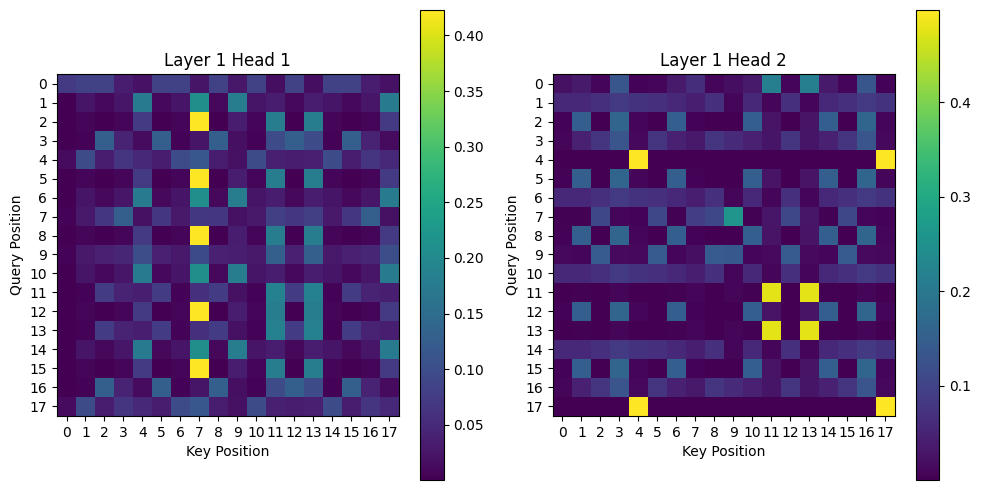

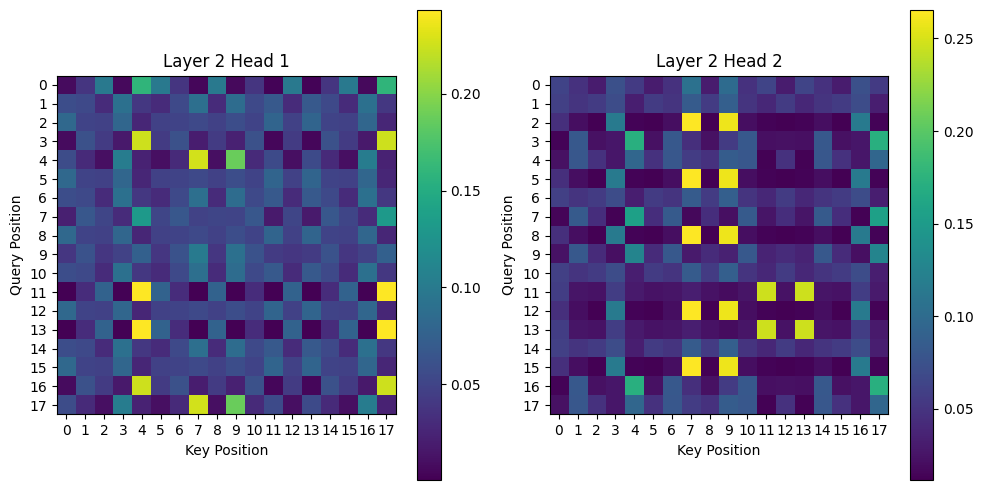

In [10]:

# Visualización de atención

@torch.no_grad()
def visualize_attention(model, prompt, max_len=16):
    model.eval()
    idx = torch.tensor([stoi[c] for c in prompt], dtype=torch.long).unsqueeze(0).to(device)
    logits, attn_weights = model(idx, return_weights=True)
    n_layers = len(attn_weights)
    n_heads = attn_weights[0].shape[1]
    seq_len = attn_weights[0].shape[2]

    for layer_i in range(n_layers):
        fig, axes = plt.subplots(1, n_heads, figsize=(5*n_heads,5))
        if n_heads == 1:
            axes = [axes]
        for head_i in range(n_heads):
            attn = attn_weights[layer_i][0, head_i].cpu()
            im = axes[head_i].imshow(attn, cmap='viridis')
            axes[head_i].set_title(f'Layer {layer_i+1} Head {head_i+1}')
            axes[head_i].set_xlabel('Key Position')
            axes[head_i].set_ylabel('Query Position')
            axes[head_i].set_xticks(range(seq_len))
            axes[head_i].set_yticks(range(seq_len))
            fig.colorbar(im, ax=axes[head_i])
        plt.tight_layout()
        plt.show()

prompt = "To be or not to be"
visualize_attention(model_moe, prompt)


# Conclusiones
Los gráficos son matrices de atención de un Transformer, donde cada imagen muestra cómo un head en una capa atiende a diferentes posiciones de la secuencia.

Observaciones por capas y heads:

Layer 1 Head 1

Se ve un patrón fuerte (columnas muy brillantes) en posiciones específicas, por ejemplo cerca de la posición 7.

Esto indica que este head se especializó en “atender” casi siempre a un mismo token clave sin importar el query.

Conclusión: este head podría estar actuando como un "ancla" o referencia global.

Layer 1 Head 2

La atención está más dispersa, aunque hay focos muy marcados (en la esquina inferior derecha y alrededor de la posición 12).

Esto sugiere que este head aprende dependencias locales y algunas más globales.

Conclusión: más variabilidad, menos “sesgo fijo”.

Layer 2 Head 1

La atención se distribuye más equilibrada que en Layer 1.

Hay patrones diagonales débiles. Indica que el modelo empieza a capturar dependencias secuenciales (cada posición se relaciona con su vecina).

Conclusión: empieza a aparecer estructura de lenguaje.

Layer 2 Head 2

También hay focos brillantes en posiciones concretas, pero distribuidos más “cuadrados”, como bloques.

Esto es típico cuando el modelo detecta subestructuras repetitivas (ej. prefijos, sufijos, segmentos dentro de la secuencia).

Conclusión: mezcla de atención local y global.

### Interpretación general:

En las primeras capas (Layer 1) la atención es más rígida o sesgada a ciertos tokens fijos. Esto suele pasar en entrenamientos iniciales: algunos heads actúan como “detectores de posición clave”.

En las capas más profundas (Layer 2) la atención se vuelve más estructurada, equilibrada y con patrones más interpretables (diagonales, bloques), lo que indica que el modelo ya está aprendiendo dependencias entre diferentes partes de la secuencia.

### Conclusiones clave:

Los heads ya muestran especialización distinta (unos se enfocan en posiciones fijas, otros en relaciones distribuidas).

Hay evidencia de que el modelo aprende dependencias locales y globales.

El entrenamiento está funcionando: no son atenciones aleatorias, sino que hay patrones emergentes claros.

# ¡Felicitaciones! 🎉

Después de completar las tareas has preentrenado satisfactoriamente para fi... ¡Ahora puedes presumir ante tus amigos sobre cómo funcionan los LLM y los GPT!